<a href="https://colab.research.google.com/github/pharringtonp19/mecon/blob/main/notebooks/optimization/Optimal_Bundle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
%%capture 
!pip install flexitext

In [19]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp 
from functools import partial 
import matplotlib.pyplot as plt 
from flexitext import flexitext
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
from mpl_toolkits import mplot3d
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [20]:
def utility_fn(A, z, x1, x2): 
  """The utility function: The first two arguments 
  parameterize the utility function"""
  return A*x1**z * x2 **(1-z)

In [21]:
def expenditure_fn(p1, p2, x1, x2):
  return p1*x1 + p2*x2 

def excess_expenditure_fn(p1, p2, m, x1, x2):
  return expenditure_fn(p1, p2, x1, x2) - m 

In [37]:
p1 = 2.0 
p2 = 3.0 
m = 27.0 
constraint_fn = partial(excess_expenditure_fn, p1, p2, m)

In [38]:
def newtons_method(f_root):

  g = lambda z: z - jnp.linalg.solve(jax.jacobian(f_root)(z), f_root(z))

  def body_fn(val):
    next_guess = g(val)
    return next_guess #jnp.array(jnp.maximum(next_guess[:-1], jnp.zeros(2)), next_guess[-1])

  def cond_fn(val):
    return jnp.linalg.norm(f_root(val)) > 1e-3

  z = jax.lax.while_loop(cond_fn, body_fn, init_val=jnp.ones(3))
  return z 

In [39]:
def F(objective_fn, constraint_fn, params):  
  x1, x2, l = params
  a1, a2 = jax.grad(objective_fn, argnums=(0, 1))(x1, x2)
  b1, b2 = jax.grad(constraint_fn, argnums=(0, 1))(x1, x2)
  return jnp.array([a1 - l*b1, a2-l*b2, constraint_fn(x1, x2)])

In [42]:
f_root = partial(F, partial(utility_fn, 2.0, 0.5), constraint_fn)

In [44]:
optimal_bundle = newtons_method(f_root)     

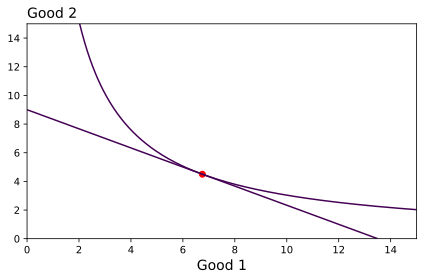

In [47]:
xp=jnp.linspace(0.,15.,200)  # N
yp=jnp.linspace(0.,15.,200)  # M

X, Y = jnp.meshgrid(xp, yp)
Z1 = constraint_fn(X,Y)
Z2 = partial(utility_fn, 2.0, 0.5)(X, Y)
fig = plt.figure(dpi=300, tight_layout=True)
plt.contour(xp,yp,Z1,levels=[0]) 
plt.contour(xp,yp,Z2,levels=[partial(utility_fn, 2.0, 0.5)(optimal_bundle[0], optimal_bundle[1])]) 
plt.title('Good 2', loc='left', size=14)
plt.xlabel('Good 1', size=14)
plt.scatter(optimal_bundle[0], optimal_bundle[1], color='red')
plt.show()